In [1]:
import pygame
import sys
from pygame.locals import *

import os
from six import moves

from Main import input_point

# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

pygame 2.6.1 (SDL 2.28.4, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html
using device: mps


In [3]:
sam2_checkpoint = "./sam2_master/checkpoints/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [4]:
SAM2image = Image.open('MyImages/ren.jpg')
SAM2image_width, SAM2image_height= SAM2image.size
SAM2image = SAM2image.convert("RGB")
predictor.set_image(SAM2image)

/Users/kolmio/PycharmProjects/SAM2kolmio/.venv/lib/python3.11/site-packages/torch/nn/functional.py:4594: UserWarning: The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_bicubic2d(


In [6]:
input_point=[(474, 184),(516, 219),(465, 219),(491, 263)]
input_label=[1,1,1,1]
masks, scores, logits = predictor.predict(
            point_coords=input_point,
            point_labels=input_label,
            multimask_output=False,
        )
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]

In [7]:
Npimage = np.array(SAM2image.convert("RGB"))
h, w = Npimage.shape[:2]
result = np.zeros((h, w, 4), dtype=np.uint8)
result[masks[0] > 0, :3] = Npimage[masks[0] > 0]
result[..., 3] = np.where(masks[0] > 0, 255, 0)

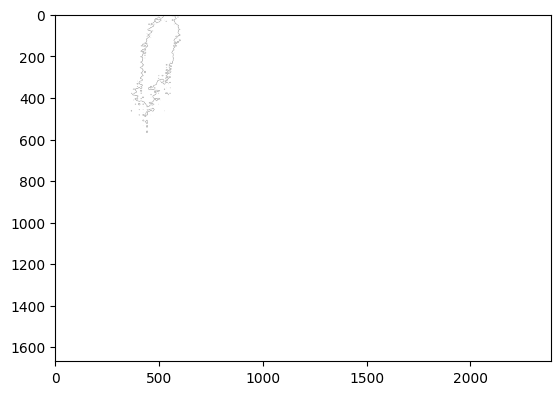

In [9]:
import matplotlib.pyplot as plt
plt.imshow(result)

In [10]:
result.shape

(1668, 2388, 4)

In [13]:
np.sum(result[600,:,:])

np.uint64(0)

In [23]:
first_h_bound=0
for i in range(result.shape[0]): 
    if np.sum(result[i,:,:])>0:
        first_h_bound=i
        break
second_h_bound=result.shape[0]
for i in range(result.shape[0]-1,0,-1):
    if np.sum(result[i,:,:])>0:
        second_h_bound=i
        break

first_w_bound=0
for i in range(result.shape[0]): 
    if np.sum(result[:,i,:])>0:
        first_w_bound=i
        break
second_w_bound=result.shape[0]
for i in range(result.shape[0]-1,0,-1):
    if np.sum(result[:,i,:])>0:
        second_w_bound=i
        break



In [20]:
first_h_bound


7

In [21]:
second_h_bound

569

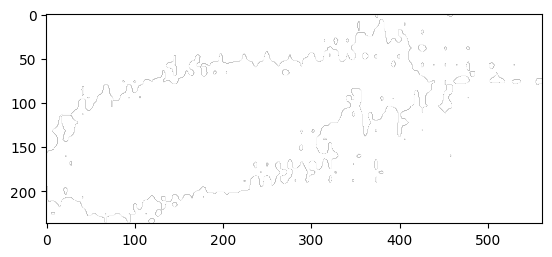

In [33]:
cut_out=result[first_h_bound:second_h_bound,first_w_bound:second_w_bound,:].copy()
rotate=np.transpose(cut_out,(1,0,2))
plt.imshow(rotate)


In [28]:
cut_out.shape

(562, 237, 4)

In [29]:
def cutoutobject(result):
    first_h_bound=0
    for i in range(result.shape[0]): 
        if np.sum(result[i,:,:])>0:
            first_h_bound=i
            break
    second_h_bound=result.shape[0]
    for i in range(result.shape[0]-1,0,-1):
        if np.sum(result[i,:,:])>0:
            second_h_bound=i
            break
    
    first_w_bound=0
    for i in range(result.shape[0]): 
        if np.sum(result[:,i,:])>0:
            first_w_bound=i
            break
    second_w_bound=result.shape[0]
    for i in range(result.shape[0]-1,0,-1):
        if np.sum(result[:,i,:])>0:
            second_w_bound=i
            break
    return result[first_h_bound:second_h_bound, first_w_bound:second_w_bound, :].copy()